# Developmental EEG Data 

This notebook analyzes a large dataset of EEG, collected from a developmental sample.

## Dataset Details

This analysis uses the 
[MIPDB dataset](http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/) from the 
[ChildMind Institute](https://childmind.org/).

Note that the pre-processing of the data as available in the dataset, doing data cleaning and calculating power spectra, is done external to this project.

In [1]:
#from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import cm

#import mne
#from mne.viz import plot_topomap

#from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_20176/1429965618.py:11: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.utils import trim_spectrum


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, load_pickle
from apm.io.data import load_eeg_dev_info
from apm.run import run_measures, run_group_measures
from apm.analysis import compute_avgs, unpack_corrs
from apm.analysis import compute_all_corrs, compute_corrs_to_feature#, compute_diffs_to_feature
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.results import plot_topo
from apm.plts.multi import plot_results_all, plot_topo_row
from apm.plts.utils import make_axes
from apm.plts.settings import EXT, LABELS
#from apm.methods import (autocorr_decay_time, hurst, dfa, higuchi_fd, hjorth_complexity,
#                         lempelziv, sample_entropy, perm_entropy, specparam, irasa)
#from apm.methods.settings import (AC_DECAY_PARAMS, HURST_PARAMS, DFA_PARAMS, HFD_PARAMS,
#                                  HJC_PARAMS, LZ_PARAMS, SA_ENT_PARAMS, PE_ENT_PARAMS)
#from apm.methods.periodic import alpha_power
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Load Data

In [4]:
# Data path
data_path = Path('/Users/tom/Data/VoytekLab/ExtractedSubsets/childmind/')

In [5]:
# Load data files
ages = np.load(data_path / 'ages.npy')
data = np.load(data_path / 'data.npy')

In [6]:
# Check the number of subjects
n_subjs = data.shape[0]
assert n_subjs == len(ages)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 111


In [7]:
# Set path for group level data
project_path = Path('/Users/tom/Documents/Research/2-Projects/1a-Current(Voytek)/AperiodicMethods/')
data_path = project_path / '2-Data/apm_data/eeg2'

In [8]:
# Load group data
group_data = np.load(data_path / 'MIPDB_extracted_block.npy')

In [9]:
# Check the size of the dataset
n_subjs, n_blocks, n_chs, n_times = group_data.shape
print('# of subjects: \t', n_subjs)
print('# of blocks: \t', n_blocks)
print('# of channels: \t', n_chs)

# of subjects: 	 111
# of blocks: 	 5
# of channels: 	 111


In [10]:
# Sub-select the first block of data
group_data = np.squeeze(group_data[:, 0, :, :])

In [11]:
# Load info
info = load_eeg_dev_info(data_path)

In [12]:
# Define load path
db = APMDB()
LOADPATH = db.data_path / 'eeg2'

In [13]:
# Check the set of results files available for this dataset
get_files(LOADPATH)

['eeg2_results.p',
 'eeg2_results_peaks.p',
 'eeg2_spatial_alpha_corr_diffs.p',
 'eeg2_spatial_alpha_corrs.p',
 'eeg2_spatial_corrs.p',
 'eeg2_spatial_exp_corrs.p',
 'zOLD']

In [14]:
# Load precomputed group results
group_results = load_pickle('eeg2_results', LOADPATH)

In [15]:
# Check of computed measures
print(list(group_results.keys()))

['autocorr_decay_time', 'dfa', 'higuchi_fd', 'hjorth_complexity', 'lempelziv', 'sample_entropy', 'perm_entropy', 'specparam', 'irasa']


In [16]:
# Check size of computed results
group_results['dfa'].shape

(111, 111)

In [17]:
# Load precomputed peak results
group_results_peaks = load_pickle('eeg2_results_peaks', LOADPATH)

In [18]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam', 'irasa']
ts_measures = list(group_results.keys())
[ts_measures.remove(meas) for meas in exp_measures];

In [19]:
# # TEMP:
# sum(sum(sum(sum(group_data == 0.0))))

## Settings

In [20]:
# Define data information
fs = 500
n_seconds = 30

In [21]:
# Define times vector for data
times = create_times(n_seconds + 1/fs, fs)

In [22]:
# Add plot kwargs
dot_kwargs = {
    's' : 24,
    'alpha' : 0.7,
}

In [23]:
# Settings for saving figures
SAVE_FIG = False
FIGPATH = db.figs_path / '52_dev_data'

## Data Checks

In [24]:
# Set example subject index
subj_ind = 2

In [25]:
# Set example channel index
chi = 110

In [26]:
# Check example channel label
info.ch_names[chi]

'Cz'

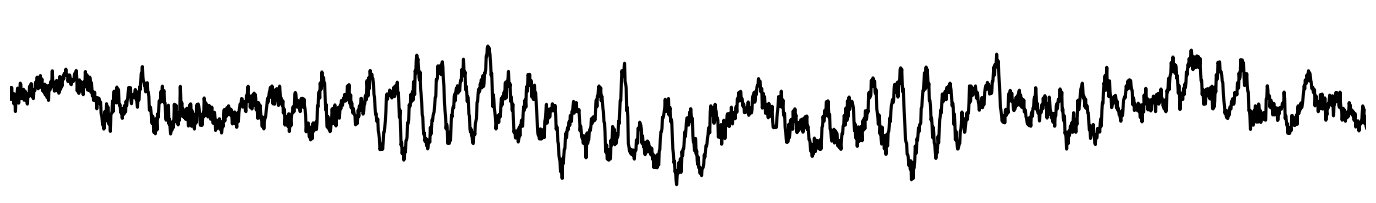

In [27]:
# Plot a segment of time series data
plot_time_series(times, group_data[subj_ind, chi], xlim=[5, 10])
plt.gca().axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('eeg_timeseries' + EXT))

In [28]:
# # Plot a segment of time series data
# plot_time_series(times, data[subj_ind, :], xlim=[5, 10])
# plt.gca().axis('off');
# if SAVE_FIG: plt.savefig(FIGPATH / ('eeg_timeseries' + EXT))

In [29]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(group_data[subj_ind, chi], fs, nperseg=2*fs, noverlap=fs)

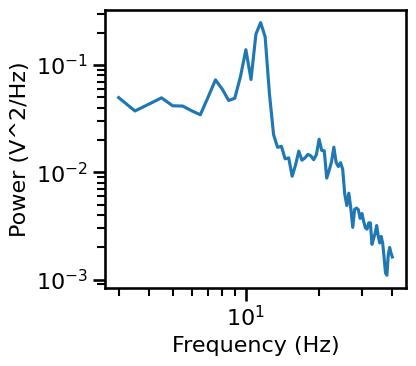

In [30]:
# Plot power spectrum of example signal
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]), figsize=(4.5, 4), 
                   save_fig=SAVE_FIG, file_name='rest_eeg_psd' + EXT, file_path=FIGPATH)

## Compute Measures Methods

This is a replication of the analysis in the initial EEG dataset. 

### Aperiodic Methods

In [31]:
# # Initialize specparam model
# fm = FOOOF(verbose=False)

In [32]:
# # General method settings
# f_range = [3, 40]
# specparam_kwargs = {'min_peak_height' : 0.05, 'fs' : fs, 'f_range' : f_range}
# irasa_kwargs = {'fs' : fs, 'f_range' : f_range}

In [33]:
# # Define measures to apply
# measures = {
#     autocorr_decay_time : AC_DECAY_PARAMS,
#     #hurst : HURST_PARAMS,
#     dfa : DFA_PARAMS,
#     higuchi_fd : HFD_PARAMS,
#     #hjorth_complexity : HJC_PARAMS,
#     lempelziv : LZ_PARAMS,
#     sample_entropy : SA_ENT_PARAMS,
#     perm_entropy : PE_ENT_PARAMS,
#     specparam : specparam_kwargs,
#     irasa : irasa_kwargs,
# }

In [34]:
# # Compute measures of interest on the data
# results = run_measures(data, measures)

In [35]:
# # Load precomputed measure results
# results = load_pickle('eeg2_results', LOADPATH)

In [36]:
# # Compute correlations across all pairs of methods
# all_corrs = compute_all_corrs(results)

In [37]:
# # Load precomputed measure correlations
# all_corrs = load_pickle('eeg2_all_corrs', LOADPATH)

In [38]:
# Sub-select results to channel of interest
results = {key : val[:, chi] for key, val in group_results.items()}
results_peaks = {key : val[:, chi] for key, val in group_results_peaks.items()}

In [39]:
# Compute correlations for selected channel
all_corrs = compute_all_corrs(results)

## Peak Measures

In [40]:
# # Define periodic measures to compute
# peak_measures = {alpha_power : measures[specparam]}

In [41]:
# # Compute periodic measures
# peak_results = run_measures(data, peak_measures)

In [42]:
# # Load precomputed peak measures
# peak_results = load_pickle('eeg2_peak_results', LOADPATH)

## Compare Measures

#### Compare Exponent Measures

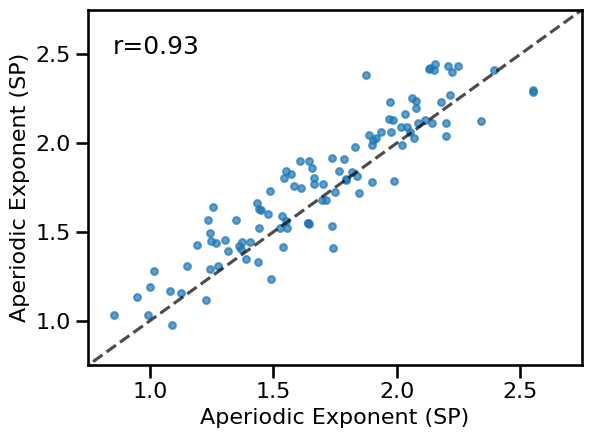

In [43]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(group_results['specparam'][:, 110], group_results['irasa'][:, 110], **dot_kwargs,
          xlim=[0.75, 2.75], ylim=[0.75, 2.75], tposition='tl', expected=[0, 3],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (SP)',
          save_fig=SAVE_FIG, file_name='mipdb_exp_exp_comp' + EXT, file_path=FIGPATH)

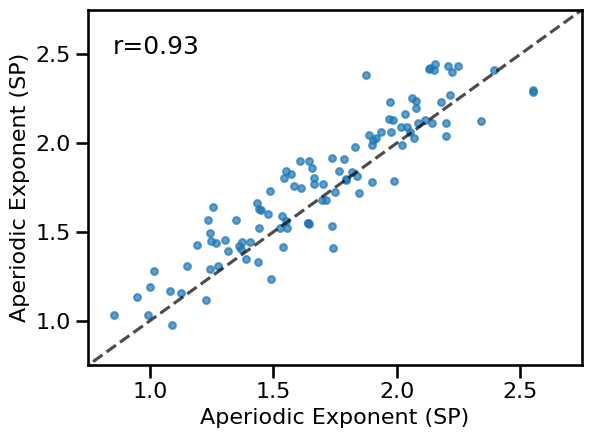

In [44]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs,
          xlim=[0.75, 2.75], ylim=[0.75, 2.75], tposition='tl', expected=[0, 3],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (SP)',
          save_fig=SAVE_FIG, file_name='mipdb_exp_exp_comp' + EXT, file_path=FIGPATH)

In [45]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.932  CI[+0.893, +0.952],  p=0.000


### Compare Exponent to Time Series Measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


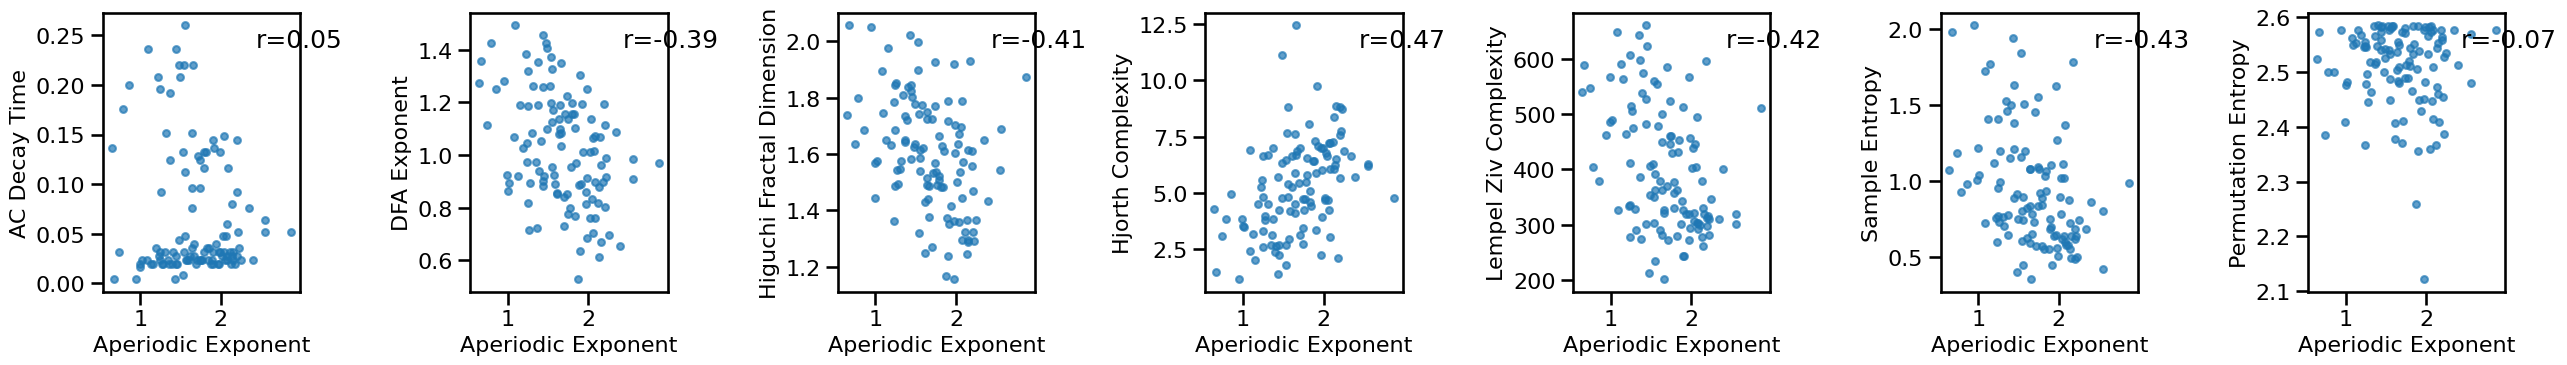

In [46]:
# Plot comparisons between exponent and time series measures
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.1)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam'], results[meas], **dot_kwargs,
              xlabel='Aperiodic Exponent', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_ts_scatters' + EXT))

In [47]:
# Check the correlations between time series and exponent measures
for meas in ts_measures:
    print(meas)
    print('    SP-EXP:  ', format_corr(*all_corrs['specparam'][meas]))
    print('    IR-EXP:  ', format_corr(*all_corrs['irasa'][meas]))

autocorr_decay_time
    SP-EXP:   r=+0.051  CI[-0.144, +0.241],  p=0.595
    IR-EXP:   r=-0.075  CI[-0.281, +0.135],  p=0.434
dfa
    SP-EXP:   r=-0.391  CI[-0.535, -0.227],  p=0.000
    IR-EXP:   r=-0.493  CI[-0.630, -0.334],  p=0.000
higuchi_fd
    SP-EXP:   r=-0.407  CI[-0.557, -0.233],  p=0.000
    IR-EXP:   r=-0.486  CI[-0.633, -0.307],  p=0.000
hjorth_complexity
    SP-EXP:   r=+0.471  CI[+0.317, +0.607],  p=0.000
    IR-EXP:   r=+0.467  CI[+0.308, +0.601],  p=0.000
lempelziv
    SP-EXP:   r=-0.422  CI[-0.569, -0.260],  p=0.000
    IR-EXP:   r=-0.409  CI[-0.550, -0.242],  p=0.000
sample_entropy
    SP-EXP:   r=-0.432  CI[-0.570, -0.267],  p=0.000
    IR-EXP:   r=-0.430  CI[-0.560, -0.275],  p=0.000
perm_entropy
    SP-EXP:   r=-0.068  CI[-0.250, +0.117],  p=0.480
    IR-EXP:   r=-0.099  CI[-0.278, +0.086],  p=0.301


### Compare Time Series Measures to Each Other

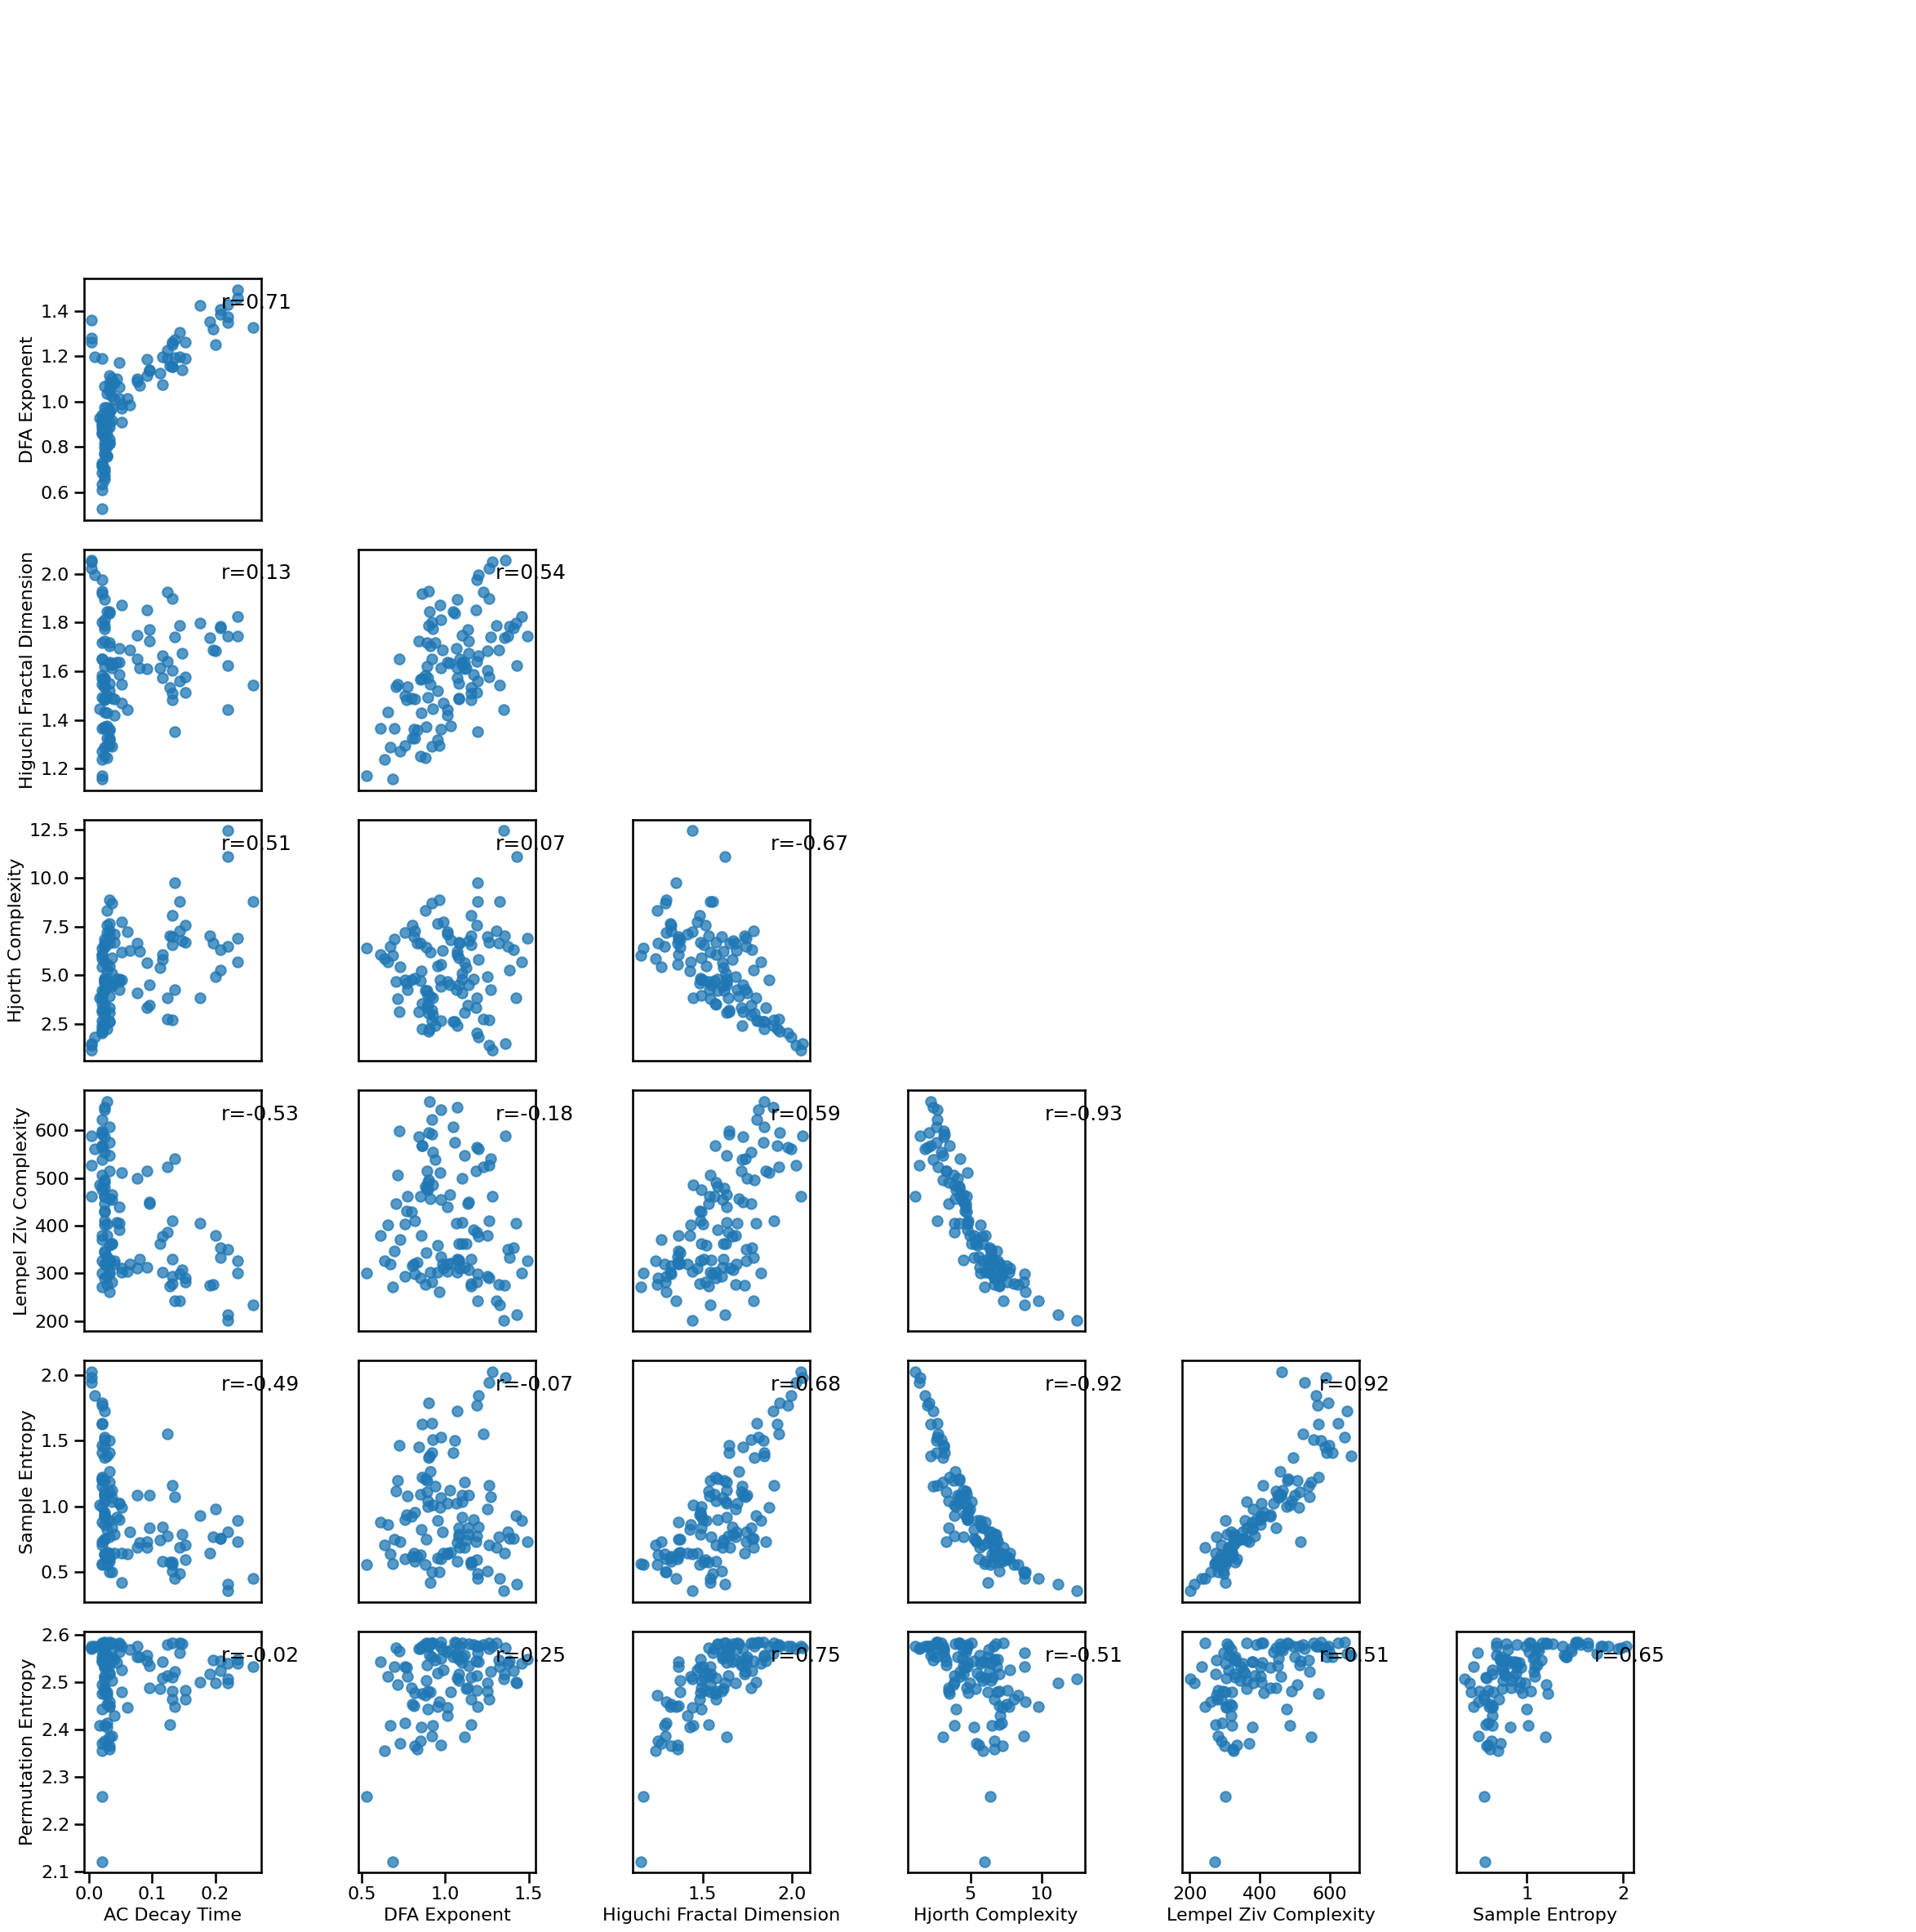

In [48]:
# Plot multi-panel plot comparing all time series measures to each other
plot_results_all(results, ts_measures)

In [49]:
# Subselect time domain measures
all_corrs_ts = {ke : va for ke, va in all_corrs.items() if ke not in exp_measures}

In [50]:
# all_corrs_ts = deepcopy(all_corrs)
# [all_corrs_ts.pop(meas) for meas in exp_measures];

In [51]:
# Unpack correlations for plotting
all_corrs_mat = unpack_corrs(all_corrs_ts)

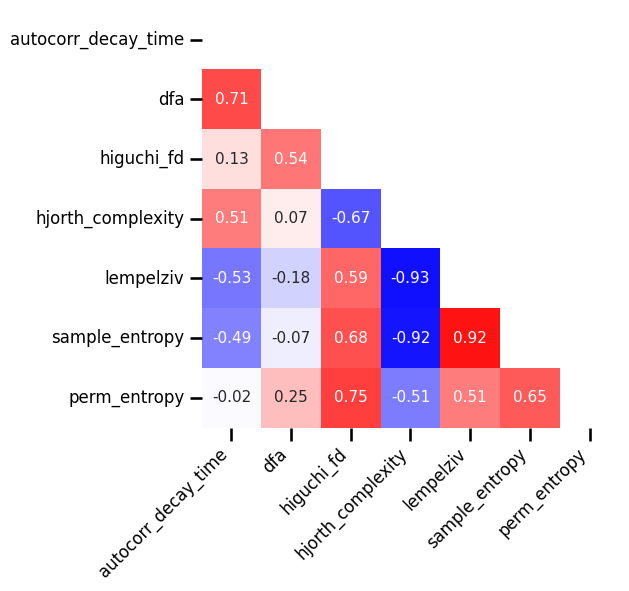

In [52]:
# ...
plot_corr_matrix(all_corrs_mat, xticklabels=ts_measures, yticklabels=ts_measures,
                 cbar=False, figsize=(6, 6))
#plt.xticks(fontsize=12, rotation=45, ha='right') 
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, fontsize=12, ha='right');
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0, fontsize=12);
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat_subjs' + EXT))

In [53]:
# Extract the correlations between specparam and time domain measures
exp_corrs_subjs = np.atleast_2d([all_corrs['specparam'][label][0] for label in ts_measures]).T

In [54]:
# exp_corrs_subjs = deepcopy(all_corrs['specparam'])
# exp_corrs_subjs.pop('irasa');
# exp_corrs_subjs = np.atleast_2d([exp_corrs_subjs[label][0] for label in ts_measures]).T

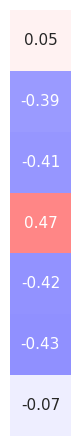

In [55]:
# ...
plot_corr_matrix(exp_corrs_subjs, xticks=[], yticks=[], cbar=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_corr_subjs' + EXT))

### Compare to Alpha Power

In [56]:
# Compute correlations between aperiodic measures and alpha power
alpha_corrs = compute_corrs_to_feature(results, results_peaks['alpha_power'])

In [57]:
# # Load precomputed correlations between aperiodic measures and alpha power
# alpha_corrs = load_pickle('eeg2_alpha_corrs', LOADPATH)

In [58]:
# # Compute differences between correlations between aperiodic measures and alpha power
# alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [59]:
# # Load precomputed differences between correlations between aperiodic measures and alpha power
# alpha_corr_diffs = load_pickle('eeg2_alpha_corr_diffs', LOADPATH)

In [60]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     autocorr_decay_time :   r=+nan  CI[+nan, +nan],  p=nan
     dfa                 :   r=+nan  CI[+nan, +nan],  p=nan
     higuchi_fd          :   r=+nan  CI[+nan, +nan],  p=nan
     hjorth_complexity   :   r=+nan  CI[+nan, +nan],  p=nan
     lempelziv           :   r=+nan  CI[+nan, +nan],  p=nan
     sample_entropy      :   r=+nan  CI[+nan, +nan],  p=nan
     perm_entropy        :   r=+nan  CI[+nan, +nan],  p=nan
     specparam           :   r=+nan  CI[+nan, +nan],  p=nan
     irasa               :   r=+nan  CI[+nan, +nan],  p=nan


In [61]:
# Organize correlations between alpha and time domain measures
alpha_corrs_ts = np.atleast_2d([alpha_corrs[label][0] for label in ts_measures]).T

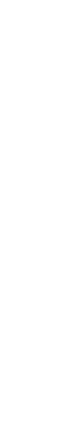

In [62]:
# Plot correlations between alpha and time domain measures
plot_corr_matrix(alpha_corrs_ts, xticks=[], yticks=[], cbar=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('alpha_corr_subjs' + EXT))

## Check Age Relationship

In [63]:
# Compute the correlations between each measure and age
age_corrs = compute_corrs_to_feature(results, ages)

In [64]:
# # Load precomputed correlations between aperiodic measures and age
# age_corrs = load_pickle('eeg2_age_corrs', LOADPATH)

In [65]:
# # Compute the differences between measure-to-age correlations
# age_corr_diffs = compute_diffs_to_feature(results, ages)

In [66]:
# # Load precomputed differences in correlations between aperiodic measures and age
# age_corr_diffs = load_pickle('eeg2_age_corr_diffs', LOADPATH)

#### Check Correlations with Age

In [67]:
# Check the correlations between age and aperiodic measures
print('Correlations with age:')
for label in age_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*age_corrs[label]))

Correlations with age:
     autocorr_decay_time :   r=-0.146  CI[-0.329, +0.040],  p=0.125
     dfa                 :   r=+0.127  CI[-0.062, +0.301],  p=0.184
     higuchi_fd          :   r=+0.157  CI[-0.021, +0.325],  p=0.101
     hjorth_complexity   :   r=-0.218  CI[-0.388, -0.027],  p=0.021
     lempelziv           :   r=+0.213  CI[+0.027, +0.385],  p=0.025
     sample_entropy      :   r=+0.297  CI[+0.123, +0.458],  p=0.002
     perm_entropy        :   r=+0.194  CI[+0.006, +0.367],  p=0.042
     specparam           :   r=-0.502  CI[-0.622, -0.357],  p=0.000
     irasa               :   r=-0.469  CI[-0.599, -0.316],  p=0.000


#### Plot age relationships

In [68]:
#sns.set_context('paper')

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


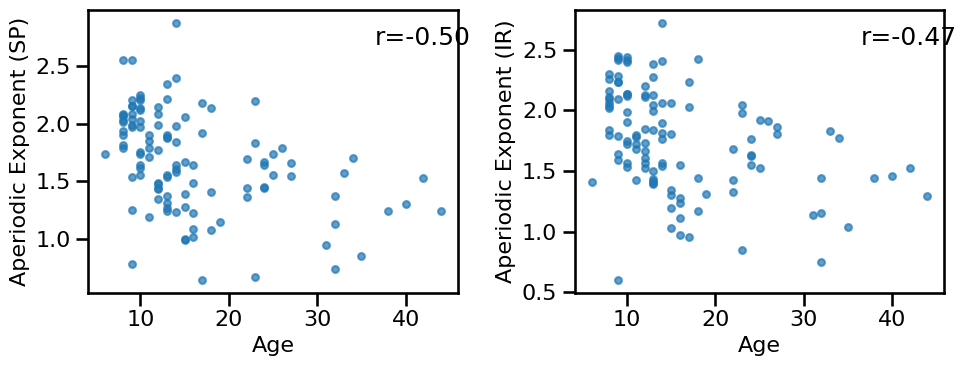

In [69]:
# Check the relationship between aperiodic exponent and age
axes = make_axes(1, 2, figsize=(10, 4), wspace=0.25)
plot_dots(ages, results['specparam'], **dot_kwargs, ax=axes[0],
          xlabel='Age', ylabel='Aperiodic Exponent (SP)')
plot_dots(ages, results['irasa'], **dot_kwargs, ax=axes[1],
          xlabel='Age', ylabel='Aperiodic Exponent (IR)')
if SAVE_FIG: plt.savefig(FIGPATH / ('mipdb_exp_age' + EXT))

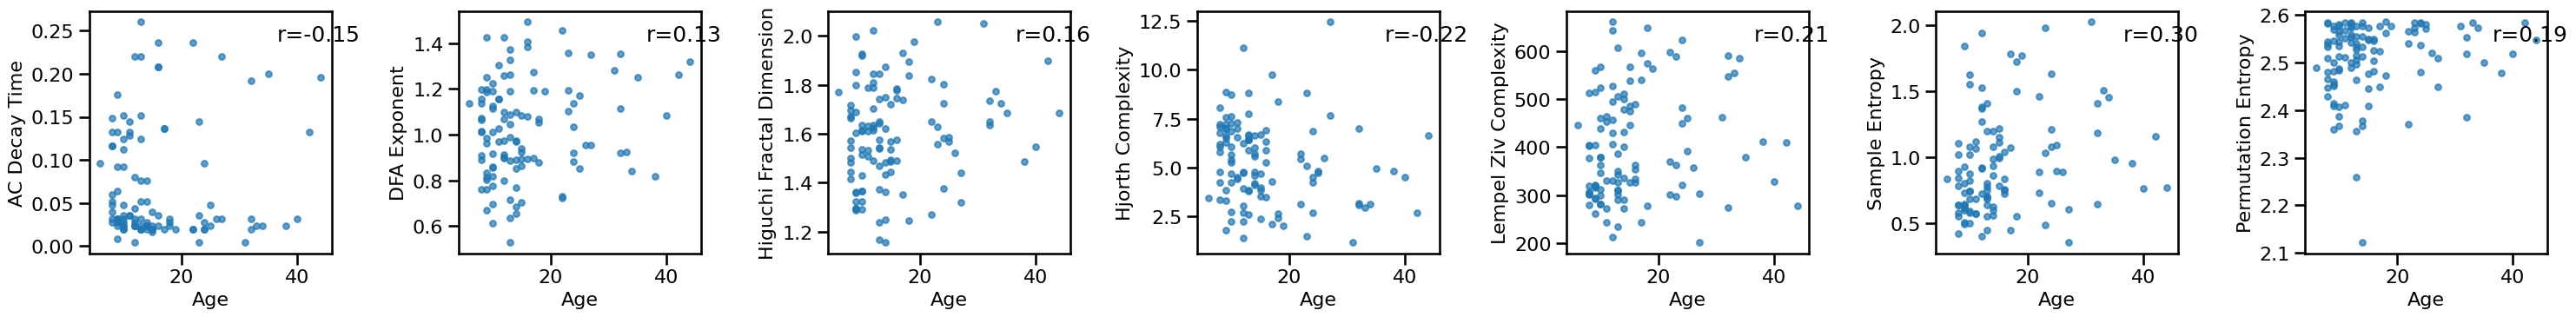

In [70]:
# Check the relationship between time domain measures and age
axes = make_axes(1, len(ts_measures), figsize=(30, 4), wspace=0.15)
for ind, meas in enumerate(ts_measures):
    plot_dots(ages, results[meas], **dot_kwargs,
              xlabel='Age', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('mipdb_ts_age' + EXT))

## Topographies

### Compute Measures Across Channels

In [71]:
# # ...
# group_results = run_group_measures(group_data, measures)

In [72]:
# Compute the group average topographies
group_avg = compute_avgs(group_results)

#### Exponent Topographies

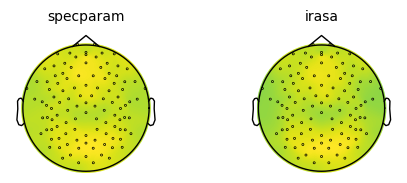

In [73]:
# Plot the group average topographies for the exponent measures
plot_topo_row(group_avg, exp_measures, info,
              save_fig=SAVE_FIG, file_name='exp_topos' + EXT, file_path=FIGPATH)

#### Time Series Measure Topographies

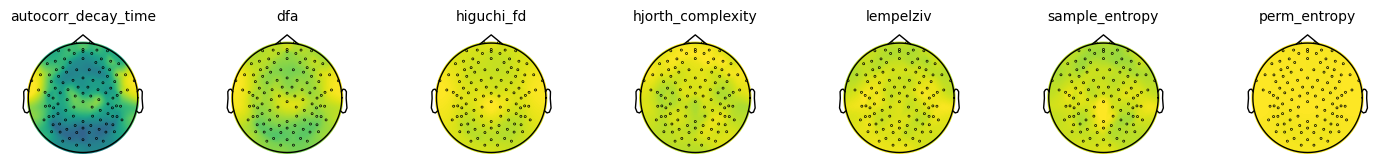

In [74]:
# Plot the group average topographies for the time domain measures
plot_topo_row(group_avg, ts_measures, info)

### Spatial Correlations

In [75]:
# group_avg_ts = deepcopy(group_avg)
# [group_avg_ts.pop(meas) for meas in exp_measures];

In [76]:
# # 
# group_corrs = compute_all_corrs(group_avg_ts)

In [77]:
# Load precomputed group correlation results
group_corrs = load_pickle('eeg2_spatial_corrs', LOADPATH)

In [78]:
# Unpack correlations for plotting
group_corrs_mat = unpack_corrs(group_corrs)

In [79]:
# ...
mask = np.triu(group_corrs_mat)
labels = list(group_corrs.keys())

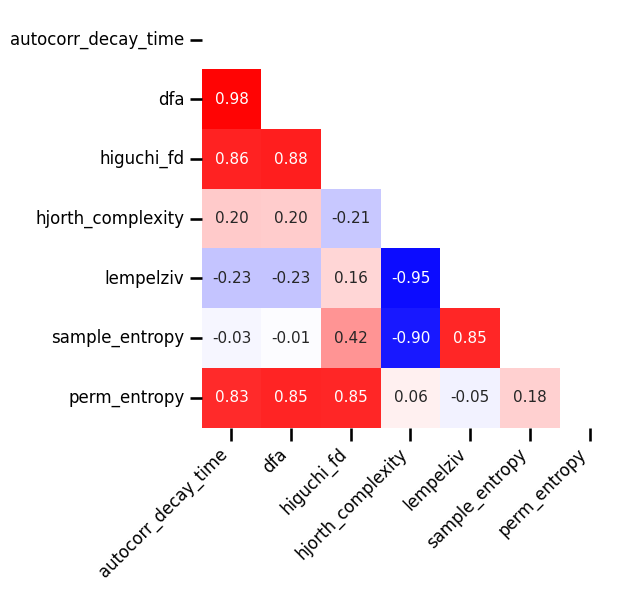

In [80]:
# ...
plot_corr_matrix(group_corrs_mat, xticklabels=ts_measures, yticklabels=ts_measures,
                 cbar=False, figsize=(6, 6))
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, fontsize=12, ha='right');
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0, fontsize=12);
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat_spatial' + EXT))

In [81]:
# group_exp_corrs = compute_corrs_to_feature(group_avg_ts, group_avg['specparam'])

In [82]:
# Load precomputed group exponent correlation results
group_exp_corrs = load_pickle('eeg2_spatial_exp_corrs', LOADPATH)

In [83]:
# Organize the correlations between the exponent and time domain measures
exp_corr_mat = np.atleast_2d([group_exp_corrs[label][0] for label in group_exp_corrs]).T

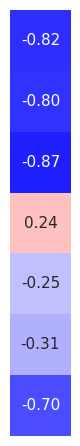

In [84]:
# Plot the correlations between exponent and time domain measures
plot_corr_matrix(exp_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_space' + EXT, file_path=FIGPATH)

### Alpha Power Topography

In [85]:
# group_results_peaks = run_group_measures(group_data, peak_measures)

In [86]:
# group_results_peaks['alpha_power'] = np.log10(group_results_peaks['alpha_power'])

In [87]:
# # Load precomputed group alpha results
# group_results_peaks = load_pickle('eeg2_group_results_peaks', LOADPATH)

In [88]:
# Compute the average alpha topography across the group
group_avg_peaks = compute_avgs(group_results_peaks)

In [89]:
# Check range of alpha power values
amin, amax = np.min(group_avg_peaks['alpha_power']), np.max(group_avg_peaks['alpha_power'])
amin, amax

(-0.7128834999534199, -0.1063998875516201)

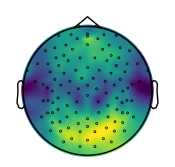

In [90]:
# Plot the average alpha topography across the group
plot_topo(group_avg_peaks['alpha_power'], info, vlim=[-0.725, -0.11])

In [91]:
# # Compute correlations between aperiodic measures and alpha power
# group_alpha_corrs = compute_corrs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [92]:
# Load precomputed correlations between aperiodic measures and alpha power
group_alpha_corrs = load_pickle('eeg2_spatial_alpha_corrs', LOADPATH)

In [93]:
# # Compute differences between correlations between aperiodic measures and alpha power
# group_alpha_corr_diffs = compute_diffs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [94]:
# Load precomputed differences between correlations between aperiodic measures and alpha power
group_alpha_corr_diffs = load_pickle('eeg2_spatial_alpha_corr_diffs', LOADPATH)

In [95]:
# Organize the alpha correlations
alpha_corr_mat = np.atleast_2d([group_alpha_corrs[label][0] for label in group_alpha_corrs]).T

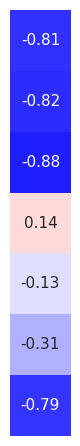

In [96]:
# Plot the correlations between alpha activity and time domain measures
plot_corr_matrix(alpha_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='alpha_corr_space' + EXT, file_path=FIGPATH)

## Comparison Across Blocks

ToDo...

## Conclusions

Interim conclusions from this analysis:
- specparam & IRASA estimates are consistent in this dataset
- aperiodic exponent is moderately correlated with time domain measures

Notably, these findings are a replication of the same analyses on the previous EEG dataset.

In addition, in this larger dataset, we could analyze the relationship between our measures of interest, and age, finding that:
- specparam & IRASA estimates of exponent are equivalently correlated with age
- time domain measures are more moderately correlated with age than exponent measures